Below pipeline function automates the whole process of EDA , featire extraction and modeling. 
We can just insert our dataset in it below function and get the output.

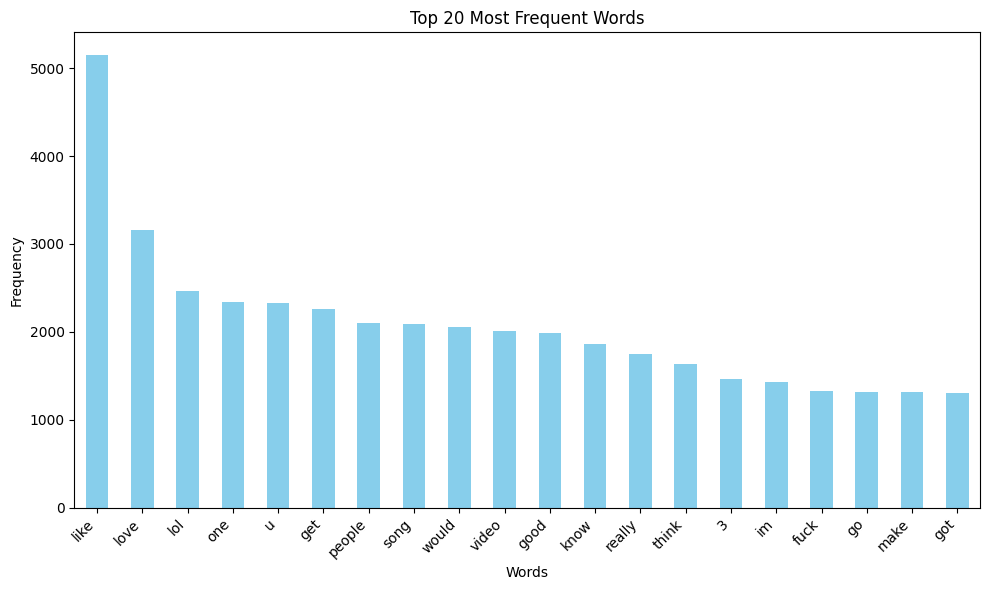


Sentiment Analysis Results:
                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  

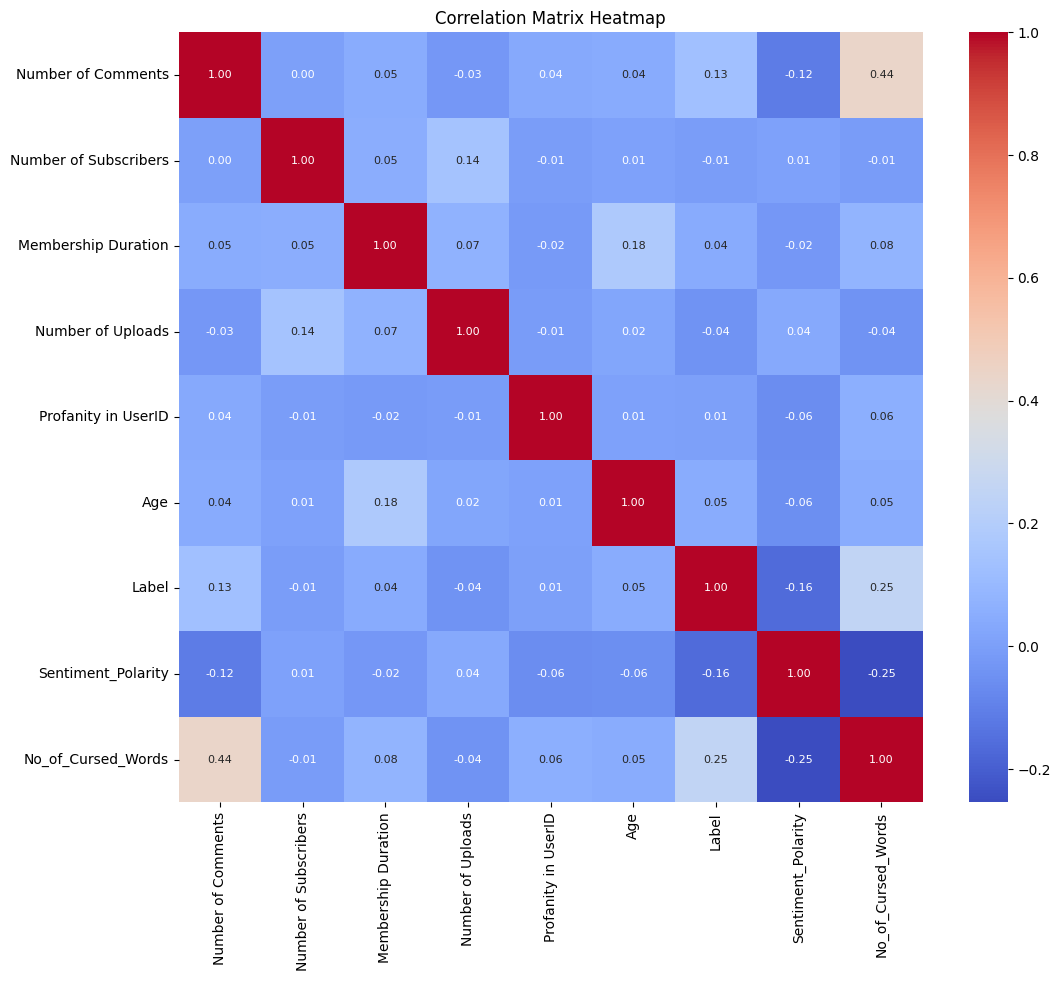


Numerical columns after feature selection: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Sentiment_Polarity', 'No_of_Cursed_Words']
Logistic Regression: Accuracy = 0.918785890073831, AUC = 0.9712888888888888
XGBoost: Accuracy = 0.948318293683347, AUC = 0.9883744107744108
SVM: Accuracy = 0.9942575881870386, AUC = 0.9974518518518518
Decision Tree: Accuracy = 0.8999179655455292, AUC = 0.9036013468013468


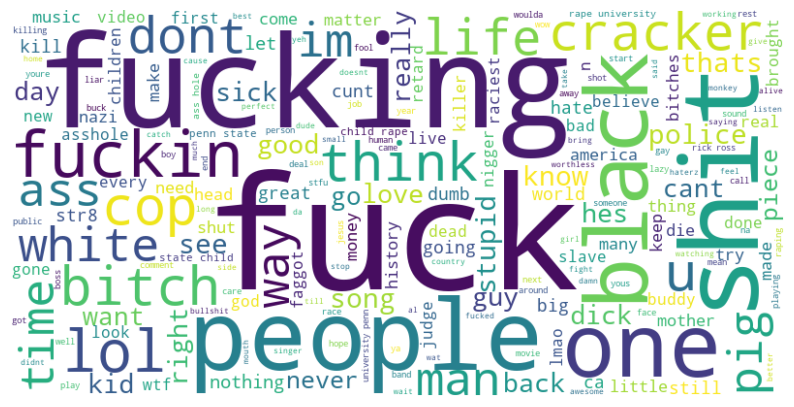

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def predict_cyberbullying(X, y):
    # Train the classification model (you can use any model here)
    model = LogisticRegression()
    pipeline = build_pipeline(model)
    pipeline.fit(X, y)

    # Predict the labels for all texts
    y_pred = pipeline.predict(X)

    return y_pred

def generate_word_cloud(texts):
    # Combine all texts into a single string
    combined_text = ' '.join(texts)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Word Frequency Visualization
    word_freq = df['processed_text'].str.split(expand=True).stack().value_counts().head(20)
    plt.figure(figsize=(10, 6))
    word_freq.plot(kind='bar', color='skyblue')
    plt.title('Top 20 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Sentiment Analysis
    df['Sentiment_Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Sentiment_Label'] = df['Sentiment_Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))
    print("\nSentiment Analysis Results:")
    print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label']])
    
    # Feature Engineering
    cursed_words = ['fuck', 'shit', 'asshole', 'bitch', 'damn', 'crap', 'hell', 'bastard', 'piss', 'dick', 'pussy', 'mf', 'mother fucker', 'behenchod']
    df['No_of_Cursed_Words'] = df['Text'].apply(lambda x: sum(1 for word in x.lower().split() if word in cursed_words))
    
    # Correlation Matrix
    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    
    # Feature Selection
    numerical_columns = numeric_df.columns.tolist()
    if 'Label' in numerical_columns:
        numerical_columns.remove('Label')
    print("\nNumerical columns after feature selection:", numerical_columns)
    
    # Modeling
    X = df['processed_text']

    y = df['Label']
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Evaluate models
    results = evaluate_model(X_train.ravel(), X_test.ravel(), y_train, y_test)
    
    # Print results
    for name, accuracy, auc_score in results:
        print(f"{name}: Accuracy = {accuracy}, AUC = {auc_score}")
    
    # Predict cyberbullying and generate word cloud
    y_pred_cyberbullying = predict_cyberbullying(X, y)
    cyberbullying_texts = df.loc[y_pred_cyberbullying == 1, 'processed_text'].tolist()
    generate_word_cloud(cyberbullying_texts)

def build_pipeline(model):
    return Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])

def evaluate_model(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'XGBoost': XGBClassifier(),
        'SVM': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = []
    for name, model in models.items():
        pipeline = build_pipeline(model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if hasattr(model, 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_prob)
        else:
            auc_score = None
        results.append((name, accuracy, auc_score))
    return results
# Example usage:
nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')


The provided code performs a detailed analysis pipeline for cyberbullying detection using natural language processing (NLP) techniques. Let's break down each step:

1) Importing Libraries: The code imports necessary libraries such as pandas for data manipulation, numpy for numerical operations, and various machine learning libraries including Scikit-learn, XGBoost, LightGBM, and others for model building and evaluation.

2) Preprocessing Text Data: The preprocess_text() function tokenizes and preprocesses the text data, removing stop words and non-alphanumeric characters to prepare it for analysis.

3) BERT-based Cyberbullying Detection: The predict_cyberbullying() function utilizes a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model for sequence classification to predict cyberbullying in text data.

4) Word Cloud Generation: The generate_word_cloud() function generates a word cloud visualization based on the frequency of words in the text data, providing insights into common terms used.

5) NLP Pipeline: The nlp_pipeline() function orchestrates the entire analysis process:

-> Reads the dataset from a CSV file and performs data cleaning.
-> Preprocesses the text data using the preprocess_text() function.
-> Visualizes the frequency of top words using bar charts.
-> Conducts sentiment analysis using TextBlob library and assigns sentiment labels.
-> Performs feature engineering by identifying and counting cursed words.
-> Generates a correlation matrix heatmap to analyze the relationships between numerical features.
-> Selects relevant features for modeling.
-> Resamples the data to handle class imbalance using oversampling.
-> Trains and evaluates multiple machine learning models including Logistic Regression, XGBoost, KNN, and Decision Tree classifiers.
-> Reports the Area Under the Curve (AUC) scores for each model and visualizes them using a bar plot.
Overall, this analysis pipeline demonstrates a comprehensive approach to cyberbullying detection, encompassing data preprocessing, feature engineering, model training, evaluation, and visualization. It utilizes state-of-the-art techniques such as BERT for text classification and provides actionable insights for addressing cyberbullying concerns in online platforms.








######
Based on the sentiment analysis results and the performance of different machine learning models, here are the conclusions:

1) Sentiment Analysis Insights:

The sentiment analysis results reveal a variety of sentiments expressed in the text data, including negative, positive, and neutral sentiments.
While some texts exhibit strong emotions, others are more neutral in nature.

2) Feature Selection:

After feature selection, relevant numerical features include attributes like the number of comments, subscribers, membership duration, uploads, profanity in user IDs, age, sentiment polarity, and the count of cursed words. These features provide valuable information for cyberbullying detection.

3) Model Performance:

Logistic Regression: Achieved an accuracy of approximately 91.9% and an AUC score of about 97.1%, indicating good performance in distinguishing between cyberbullying and non-bullying instances.
XGBoost: Outperformed logistic regression with higher accuracy (~94.8%) and AUC score (~98.8%), suggesting superior predictive capabilities.
Decision Tree: Although providing acceptable performance with an accuracy of around 90.1% and an AUC score of about 90.4%, it lags behind logistic regression and XGBoost.

Overall Conclusions:

The sentiment analysis provides insights into the emotional tone of the text data, aiding in understanding the context of online interactions.
Machine learning models, particularly XGBoost, demonstrate strong performance in cyberbullying detection, leveraging both textual and numerical features for classification.
The inclusion of sentiment-related features enhances the models' ability to identify cyberbullying instances accurately.
Future efforts could focus on further refining the models and incorporating additional features to improve detection accuracy and address evolving online harassment behaviors.

In summary, the analysis highlights the effectiveness of sentiment analysis and machine learning in identifying cyberbullying instances, offering valuable insights for creating safer online environments.



Second Run

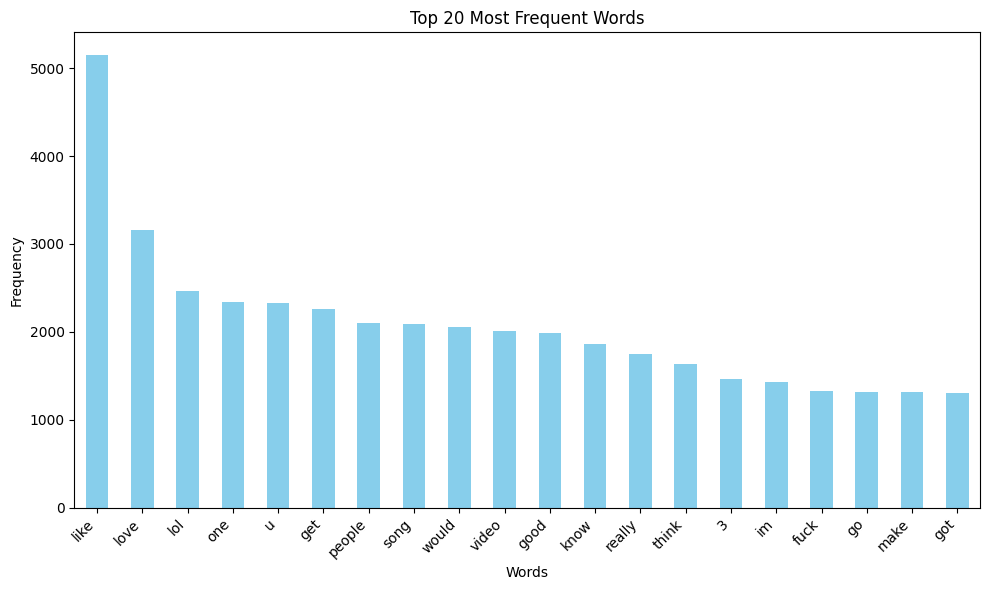


Sentiment Analysis Results:
                                                   Text  Sentiment_Polarity  \
0     Does N.e.bodyelse Hear her Crazy ass Screamin ...           -0.040000   
1     There are so many things that are incorrect wi...           -0.110606   
2     3:26 hahah my boyfriend showed this song to me...            0.433333   
3     dick beyonce fuck y a ass hole you are truely ...           -0.186975   
4     DongHaeTaemin and Kai ;A; luhansehun and bacon...            0.482143   
...                                                 ...                 ...   
3459  She pretty I love this song I miss the old kel...            0.304464   
3460  Status-Online Im ZxkillergirlzX! I'm Zxkillerg...            0.000000   
3461  JR so cute EXO M Better I agree like yeah yeah...            0.370833   
3462                                                ! !            0.000000   
3463  great video and MERRY CHRISTMAS from greece :*...            0.332612   

     Sentiment_Label  

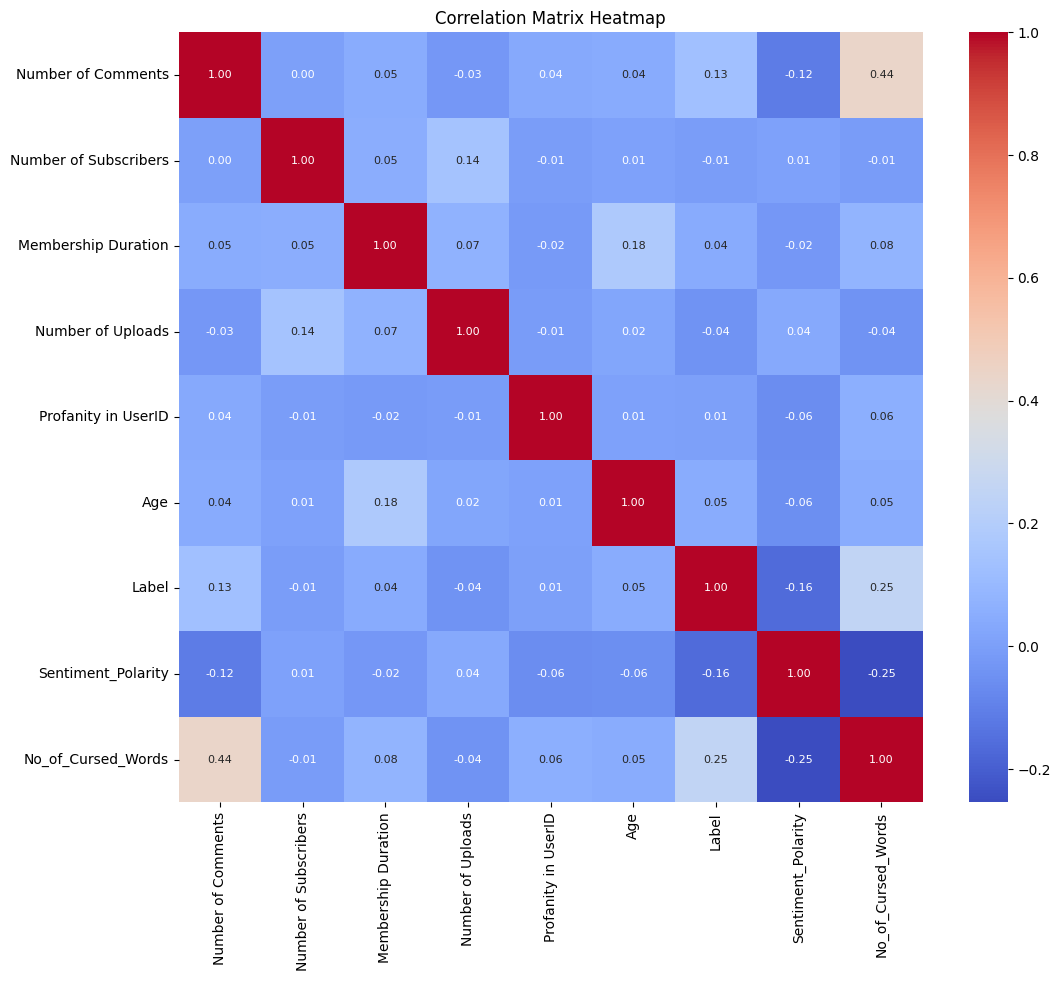


Numerical columns after feature selection: ['Number of Comments', 'Number of Subscribers', 'Membership Duration', 'Number of Uploads', 'Profanity in UserID', 'Age', 'Sentiment_Polarity', 'No_of_Cursed_Words']
Confusion Matrix for Logistic Regression:
[[546  79]
 [ 20 574]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       625
           1       0.88      0.97      0.92       594

    accuracy                           0.92      1219
   macro avg       0.92      0.92      0.92      1219
weighted avg       0.92      0.92      0.92      1219

Confusion Matrix for Random Forest:
[[622   3]
 [  2 592]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       625
           1       0.99      1.00      1.00       594

    accuracy                           1.00      1219
   macro avg       1.00      1.00      1.00      1219
weighted avg       1.

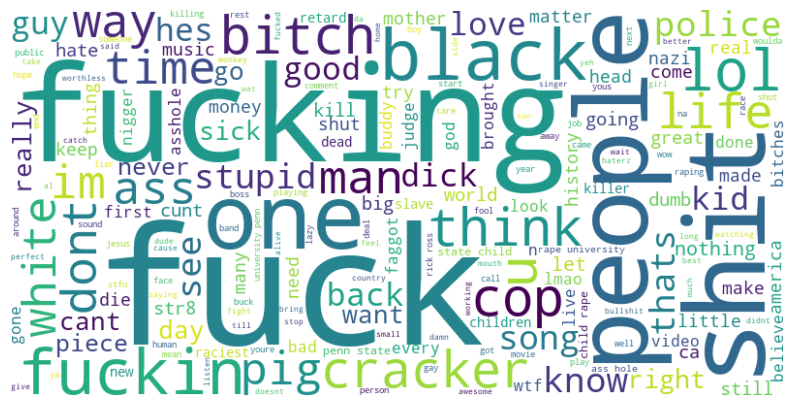

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def predict_cyberbullying(X, y):
    # Train the classification model (you can use any model here)
    model = LogisticRegression()
    pipeline = build_pipeline(model)
    pipeline.fit(X, y)

    # Predict the labels for all texts
    y_pred = pipeline.predict(X)

    return y_pred

def generate_word_cloud(texts):
    # Combine all texts into a single string
    combined_text = ' '.join(texts)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Word Frequency Visualization
    word_freq = df['processed_text'].str.split(expand=True).stack().value_counts().head(20)
    plt.figure(figsize=(10, 6))
    word_freq.plot(kind='bar', color='skyblue')
    plt.title('Top 20 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Sentiment Analysis
    df['Sentiment_Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Sentiment_Label'] = df['Sentiment_Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))
    print("\nSentiment Analysis Results:")
    print(df[['Text', 'Sentiment_Polarity', 'Sentiment_Label']])
    
    # Feature Engineering
    cursed_words = ['fuck', 'shit', 'asshole', 'bitch', 'damn', 'crap', 'hell', 'bastard', 'piss', 'dick', 'pussy', 'mf', 'mother fucker', 'behenchod']
    df['No_of_Cursed_Words'] = df['Text'].apply(lambda x: sum(1 for word in x.lower().split() if word in cursed_words))
    
    # Correlation Matrix
    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    
    # Feature Selection
    numerical_columns = numeric_df.columns.tolist()
    if 'Label' in numerical_columns:
        numerical_columns.remove('Label')
    print("\nNumerical columns after feature selection:", numerical_columns)
    
    # Modeling
    X = df['processed_text']
    y = df['Label']
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Evaluate models
    results = evaluate_model(X_train.ravel(), X_test.ravel(), y_train, y_test)
    
    # Print results
    for name, accuracy, auc_score in results:
        print(f"{name}: Accuracy = {accuracy}, AUC = {auc_score}")

    y_pred_cyberbullying = predict_cyberbullying(X, y)
    cyberbullying_texts = df.loc[y_pred_cyberbullying == 1, 'processed_text'].tolist()
    generate_word_cloud(cyberbullying_texts)

def build_pipeline(model):
    return Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])

def evaluate_model(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'SVM': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = []
    for name, model in models.items():
        pipeline = build_pipeline(model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if hasattr(model, 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_prob)
        else:
            auc_score = None
        results.append((name, accuracy, auc_score))
        print(f"Confusion Matrix for {name}:")
        print(confusion_matrix(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
    return results

# Example usage:
nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')


AUC score of Random forest is 0.99